# Week 1

## Syllabus and class structure
Welcome to the course *Decoding the Brain*. We will cover how to process electrical signals generated by neural activity, use machine learning approaches to infer the presentation of stimuli or an intended motor action from that activity, and evaluate the performance of these inferences. 

The is designed so that students gain a practical understanding of how to design the algorithms used for brain-computer interfaces (BCI). By the end of the course, you should understand enough to program your own BCI algorithms for non-invasive (scalp) and invasive (electrodes implanted in the brain) measures of brain activity. These activities can be weak electrical activity recorded from the scalp (EEG), high-frequency oscillations recorded on the brain surface (ECoG), and the firing of individual neurons (units). Decoding each of these types of signals requires several steps we will cover. First, you will be shown how to process and clean them for subsequent decoding. Then, we will cover the theory behind how the decoding algorithms work and code basic versions of them from scratch in Python. Next, we will expand their capabilities to handle more complex patterns of brain activity or decode multiple events. Finally, we will evaluate the decoder's performance.

Except for cursory discussion, we will not cover the hardware, surgical, and biocompatibility issues of recording brain activity. Those topics depend upon a fundamentally different skill-set from the design of BCI algorithms. 

The two principal algorithms covered in this course, logistic regression and naive Bayes, are useful outside of BCIs. Thus, the understanding you get of them here will apply to many other domains.

## Mixing code, theory, and practice
Lectures will introduce the theory behind what we do, practical details of how to go about doing it, and code that does the doing. The astounding thing about BCI is how accessible the algorithms and plentiful the data sources are. Of course, a real BCI system uses specialized hardware implanted in or on a person and is run in near real-time, which is not feasible in a classroom setting. 

We will use Python throughout this course, and publicly available data sets.

In [1]:
# This will be the standard set of packages we import for most lectures. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Neuroscience basics
The brain is an electro-chemical machine that allows vertebrates to interact with a dynamic complex environment. It does this using specialized cells called *neurons*. They have the ability to receive chemical signals, *neurotransmitters*, that affect their electrical activity. This activity is transmitted to other neurons via an *axon*. When multiple neurons are connected together they form a network that supports the transformation of incoming activity and spontaneous generation of new activites.

### Brain anatomy
Multiple structural/circuit levels
SCALP -> SKULL -> ARACHNOID/DURA/PIA -> BRAIN

### Neurons
Neurons are the principal cell type in the brain for processing information. Neurons are tiny, ~10 microns, which is 5-10 times smaller than the diameter of a human hair. They are comprised of a soma (cell body), dendrites, and an axon. The dendrites take in signals from other neurons, integrate them, and convey them to the soma. When these signals exceed a threshold, the soma can generate an *action potential* that is conveyed down the axon towards other neurons. 

### Membranes and ions
Like all eukaryotic cells, neurons have a lipid membrane that seals in their internal, or *intracellular*, fluid (also known as cytoplasm) and organelles from the *extracellular* environment. This membrane also acts as an electrical insulator, blocking the flow of electrical charges across it. Electrical charge in the brain is carried by *ions* in the intracellular and extracellular fluids (cerebrospinal fluid). Ions are atoms that can be either positively or negatively charged depending on whether they have a fewer or greater number of electrons than protons. The ones that are most determinative of neural activity are Na<sup>+</sup>, K<sup>+</sup>, Cl<sup>-</sup>, and Ca<sup>2+</sup>. Between the intracellular and extracellular fluids, the concentrations of these ions are different. Na<sup>+</sup>,Cl<sup>-</sup>, and Ca<sup>2+</sup> have higher concentrations in the extracellular fluid, while K<sup>+</sup> ions have a higher concentration in the intracellular fluid. 

In [2]:
ion_props = pd.DataFrame({'Ion': ['Na', 'K', 'Cl', 'Ca'],
                          'Out_mM': [140, 3, 140, 1.5],
                          'In_mM': [7, 140, 7, 0.0001],
                          'Charge': [1, 1, -1, 2]})
ion_props.set_index('Ion', inplace=True)

print(ion_props)

     Out_mM     In_mM  Charge
Ion                          
Na    140.0    7.0000       1
K       3.0  140.0000       1
Cl    140.0    7.0000      -1
Ca      1.5    0.0001       2


This uneven distribution of ions across the membrane is unstable because ions tend to flow from where they are highly concentrated to where they are less concentrated. To cross the membrane, ions flow through channels, unsurprisingly called *ion channels*. These are proteins that span the inside and outside of the neuron with a central hole through which the ions flow. The pore's shape and charge determine its selectivity for specific ionic species. Additional factors can control the opening of the pore. Some ion channel pores are controlled by the voltage across the membrane, others by substances such as neurotransmitters or hormones that bind to them, or even other ions like Mg<sup>2+</sup>.

Since ions move from high to low concentrations, Na<sup>+</sup>, Cl<sup>-</sup>, and Ca<sup>2+</sup> are inclined to flow into neurons. K<sup>+</sup>, on the other hand, wants to flow out of the neuron. As these ions flow through the membrane they build up on its surface. This create a force that opposes further flow from diffusion, because ions with the same sign to their charge tend to push away from each other. The work needed to move a charge from one place to another is measured as a *voltage* or *potential*. The potential at which an ion's electrical forces from the buildup of ions balance out the diffusion force is referred to as the *reversal potential*, E. In the case here, we are measuring potential between the inside and outside of the neuron. We can calculate the strength of the potentials that reflect these drives using the Nernst equation.

$$E = \frac{RT}{zF}ln\frac{[Out]}{[In]}$$

$R$ is the gas constant and $F$ is Faraday's constant, while $T$ is temperature in Kelvin and $z$ is the charge of the ion. $[Out]$ and  $[In]$ are the extracellular and intracellular concentrations of that ion, respectively.

Most of the time when an equation is introduced, we will try to translate it into Python. A method that calculates the equilibrium potential of a given ion can be given as:

In [3]:
# calculate Nernst equilibrium potential for an ion
def nernst(conco=3, conci=140, z=1, t=310):
    """Calculate Nernst potential for an ion.
    
    Parameters
    ----------
    conco : float
        Concentration of ion outside cell (mM). Default is for K+.
    conci : float
        Concentration of ion inside cell (mM). Default is for K+.
    z : int
        Charge of ion.  Default is for K+.
    t : float
        Temperature (Kelvin). Default is body temperature.
    
    Returns
    -------
    float
        Nernst potential for ion (mV).
    """
    r = 8.314 # J/mol/K, gas constant
    f = 96485 # C/mol, Faraday's constant
    return (r*t)/(z*f) * np.log(conco/conci) * 1000

Using this function and the dataframe of ionic concentrations above, we can calculate the equilibrium potentials for each of the major ionic species found in the nervous system.

In [5]:
ion_props['E'] = ion_props.apply(lambda ion: nernst(ion['Out_mM'], ion['In_mM'], ion['Charge']), axis=1)
print(ion_props)

     Out_mM     In_mM  Charge           E
Ion                                      
Na    140.0    7.0000       1   80.023015
K       3.0  140.0000       1 -102.656323
Cl    140.0    7.0000      -1  -80.023015
Ca      1.5    0.0001       2  128.430326


Several insights are readily apparent from cursury inspection of the calculated equilibrium potentials and consideration of the Nernst equation. First, and most importantly, positive ions that have a higher concentration outside the neuron will have positive potentials, while those more concentrated inside the neuron have negative potentials. This is stands out when comparing the potential of Na<sup>+</sup>, whose potential is **X** and K<sup>+</sup>, whose potential is -**X**. Second, since we are taking the ratio between $[Out]$ and  $[In]$, the overall amount of ions in our system does not affect the potential, only their relative proportion. Put another way, you could decrease the concentration of Na<sup>+</sup> ions inside and outside the neuron by ten times and as long as they have the same proportion, the potential will be unchanged. Indeed, Ca<sup>2+</sup> has a much lower overall concentration inside and outside the membrane, but its reversal potential is higher than that for Na<sup>+</sup>. Third, if an ion has a negative charge, $z$, it flips the sign of the potential. For instance, Cl<sup>-</sup> ions have a higher concentration outside the neuron, just like Na<sup>+</sup>, but their potential is negative.

The potential across a neuron's membrane is the mean of all these potentials, each weighted by how easy it is for the ion to cross the membrane, which is related to the number of open ion channels allowing that ion to flow. In a neuron at rest, mostly K<sup>+</sup> ion channels are open, so its reversal potential dominates. Neurons in the cerebral cortex usually have a resting potential around -65 mV. 

## Electrical model of the neuronal membrane
The electrical behavior of the membrane can be approximated by a relatively simple circuit. While this is not an electronics course, I will briefly describe this model and use it to construct a simulated neuron. This should allow us to explore some of the response properties of neurons and how they are reflected in the electrical activities detected with electrodes.

### Equilibrium potential as a battery and conductor
The equilibrium potential, $E_{r}$, behaves like a battery. The ionic current it produces flows through open ion channels, which we will refer to as conductors [PLACE SIDEBAR HERE ABOUT RELATIONSHIP BETWEEN RESISTANCE AND CONDUCTANCE]. As we discussed above, when a neuron is at rest it primarily allows K<sup>+</sup> ions to flow. This passive leakage of ions across the membrane has given the conductance the name *leak conductance*. This can be schematized below as a battery and condctor in series that bridge the intracellular and extracellular spaces.

BATTERY/CONDUCTOR DIAGRAM

By itself, this circuit will fix the voltage across the neuronal membrane (measured between the inside and outside) at the resting potential. Normally neurons do not remain at rest, but have a ongoing fluctuations in their membrane voltage due to the thousands of synaptic inputs they recieve. This means that the membrane potential, $V_{m}$, can be different from $E_{r}$. When $V_{m}$ is different from $E_{r}$, their is a net flow of current across the membrane, since the electrical and diffusion forces are no longer balanced (think back to the Nernst equation). The ionic current can be described using Ohm's law:

$$ V = IR $$

where $V$ is voltage (volts, V), $I$ is current (amperes, A), and $R$ is resistance (ohms, $\Omega$). Rewriting the equation to solve for $I$ gives us:
$$ I = \frac{V}{R} $$
The inverse of resistance is conductance (siemens, S), so this equation can be rewritten as:
$$ I = gV $$
Here $g$ is the ease with which our conductor allows current to flow. Now, if we include the effect of the reversal potential, $E_{r}$ acting as a battery, then the equation can be written as:
$$ I_{leak} = g_{leak}(V_{m}-E_{r}) \tag{1} $$
Let's consider the behavior of this equation. It shows that as we increase the ion channel's conductance, $g_{leak}$, the current will increase as well. It also shows that the magnitude and direction of the current will depend on the membrane voltage, $V_{m}$. If the $V_{m}$ is below the $E_{r}$, current will be negative. If it is above, then it will be positive. Interestingly, as $V_{m}$ approaches $E_{r}$, the current gets smaller. When they are equal, no current flows because the electrical forces perfectly balance the concentration gradient. 

Let's graph these relationships between $V_{m}$ and $I_{leak}$ by systematically varying $E_{r}$ and $g_{leak}$. 

In [36]:
# Here are somme realistic parameters for a neuron
mem_r = 25e3 # ohm*cm^2, taken from Egger et al 2020
cell_radius = 30e-4 # cm, 30 microns, this is larger than the cell body itself to account for membrane from dendrites
cell_area = 4*np.pi*cell_radius**2 # cm^2
g_leak = (1/mem_r) * cell_area # S/cm^2
e_rest = -0.065 # V, 65 mV

# code for solving for leak current
def ionic_current(v=0, g=g_leak, e=e_rest):
    """Calculate ionic current.
    
    Parameters
    ----------
    v : float
        Membrane potential (V). Default is 0.
    g : float
        Conductance (S). Default is leak conductance.
    e : float
        Equilibrium potential (V). Default is resting potential.
    
    Returns
    -------
    float
        Ionic current (A).
    """
    return g * (v - e)

Text(0.5, 1.0, 'Effect of conductance on ionic current')

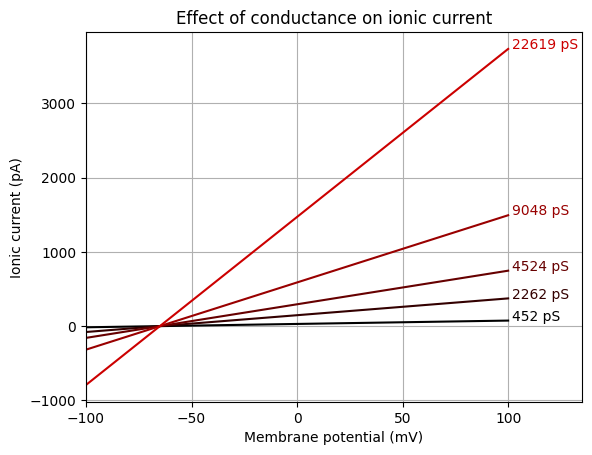

In [37]:
# Examine how varying the conductance affects the I-V curve
v = np.linspace(-0.1, 0.1, 100)
g_factors = [0.1, 0.5, 1, 2, 5]
for ind, curr_factor in enumerate(g_factors):
    curr_g = g_leak*curr_factor
    plt.plot(v*1e3, ionic_current(v, g=curr_g)*1e12, 
             label=round(curr_g*1e12), color=[ind/len(g_factors), 0,0])
    plt.text(v[-1]*1e3+2, ionic_current(v[-1], g=curr_g)*1e12,
                str(round(curr_g*1e12))+' pS', color=[ind/len(g_factors), 0,0])
plt.xlim(-100, 135)
plt.xlabel('Membrane potential (mV)')
plt.ylabel('Ionic current (pA)')
plt.grid()
plt.title('Effect of conductance on ionic current')

It is evident that increasing the conductance dramatically increases the ionic current. Now let's examine how the effect of equilibrium potential.

Text(0.5, 1.0, 'Effect of reversal potential on ionic current')

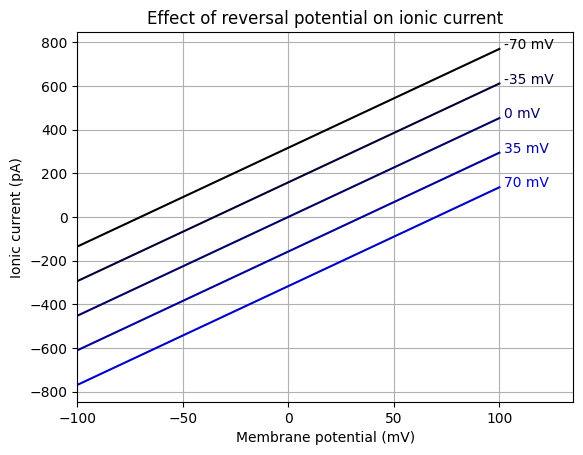

In [48]:
# Examine how varying the equilibrium potential affects the I-V curve
v = np.linspace(-0.1, 0.1, 100)
e_values = [-0.070, -0.035, 0, 0.035, 0.070]
for ind, curr_e in enumerate(e_values):
    plt.plot(v*1e3, ionic_current(v, e=curr_e)*1e12, 
             label=curr_e*1e3, color=[0,0,ind/len(e_values)])
    plt.text(v[-1]*1e3+2, ionic_current(v[-1], e=curr_e)*1e12,
                str(round(curr_e*1e3))+' mV', color=[0,0,ind/len(e_values)])
plt.xlim([-100, 135])
plt.xlabel('Membrane potential (mV)')
plt.ylabel('Ionic current (pA)')
plt.grid()
plt.title('Effect of reversal potential on ionic current')

As we shift the value of the equilibrium potential, the voltage at which the ionic current shfits from negative to positive shifts in tandem.

By itself, this circuit does not produce any intersting temporal dynamics or integrative abilities. To begin to capture those, we need to incorporate another detail about the electrical properties of the neuronal membrane.

### Membrane as a capacitor
The neuron's membrane is conceived of as a capacitor (see https://doi.org/10.1016/S0006-3495(00)76293-X for more info). A capacitor is composed of an insulator sandwiched between two conductors, in our case the lipid membrane acts as the insulator since charge cannot cross it, and the extracellular and intracellular ionic solutions are the conductors. Since each charge puts out an electric field attracts the opposite charge and repels the same charge, and this field decays with distance from the charge, the thinner the insulator is the stronger charges on either side of it can influence each other. If positive charges build up on one side of the capacitor, then they will draw negative charges to build up on the opposite side. The ability of a capacitor to store charge is quantified by its capacitance:

$$ C = \frac{\epsilon\epsilon_{0}A}{d} $$

where $\epsilon$ is the dielectric constant of the insulation material, $\epsilon_{0}$ is the polarizability of free space, $A$ is the surface area of the capacitor, and $d$ is the thickness of the insulator. Capacitance is measured in the unit Farads (F). This equation tells us that to increase capcitance one should enlarge the surface area of the capacitor, allowing more space to accomodate charge, and shrink the thickenss of the insulator, making it easier for charges on either side to interact. 

What value does the capacitance take for neurons? Since all membranes are composed of a lipid bilayer, they do not differ in their material composition so their $\epsilon$ stays the same, and $\epsilon_{0}$ is a physical constant that does not change. The thickness of the neuronal membrane, $d$, our insulator, is also consistent across neurons, with a value ~9 nm. But, since neurons can vary in size, $A$ varies greatly across neurons. So, we often use 'specific capacitance', which is the ratio between capacitance and area. The specific capacitance for neurons is generally around 1 uF/cm<sup>2</sup>. If we approximate a neuron as a sphere, then its capacitance can be calculated using its radius to calculate the area of the sphere ($A=4 \pi r^2$), and multiplying that by the 1 uF/cm<sup>2</sup>. For instance, a neuron with a radius of 10 um has a capacitance of 12.5 pF.

### Passive electrical model of the membrane
Expanding our electrical schematic we add the membrane capacitor in parallel with the resting potential battery and conductor. This is the *passive* electrical model of the membrane. Many classic phenomena of neural integration arise from the passive electrical behavior of its membrane. 

BATTERY/CONDUCTOR CAPACITOR DIAGRAM

The battery charges up the capacitor, forcing it to adopt a potential equal to the resting potential. Once it has reached this stable state, what if were to artificially inject a current into the neuron? To calculate this, we can use a rule from electrical theory called Kirchoff's current law (see https://en.wikipedia.org/wiki/Kirchhoff%27s_circuit_laws#Kirchhoff's_current_law). It states that the current flowing into a node of an electrical circuit must equal the current flowing out of it. We already have an equation (EQ X) that describes the current produced by our ionic leak current, now we need to know how to calculate the current produced by the capacitor.

The relationship between current and voltage for a capacitor is described by the equation:

$$ I = C\frac{dV}{dt} \tag{2}$$

What this means is that the current produced across the capacitor is proportional to the change in voltage. 

The passive electrical circuit model is also known as an *RC circuit*, because it contains a resistor and capacitor. What is its behavior? When it is first put together, there is no voltage across the capacitor, so the battery will charge it up. However, the resistor places a limit on the current, meaning the capacitory will not fully charge instantly. To determine the trajectory the voltage will take, we can model this with an equation by combining equations 1 and 2 using Kirchoff's current law. For the circuit above, this yields the equation:
$$ \begin{align} 
    \notag
    0 &= I_{rest} + I_{C} \\ \notag
    0 &=g_{m}(V_{m}-E_{rest}) + C_{m}\frac{dV_{m}}{dt} \\ \notag
    -C\frac{dV_{m}}{dt}&=g_{m}(V_{m}-E_{rest}) \\ \notag
    \frac{dV_{m}}{dt}&=-\frac{g_{m}}{C}(V_{m}-E_{rest})
    \end{align}
$$

This is a differential equation that can be solved to give voltage as a function of time:
$$ V_{m}(t) = E_{rest}(1-e^{\frac{-t}{\frac{g_{m}}{C_{m}}}}) $$

Rewriting $g_{m}$, as its inverse, referred to as membrane resistance, $R_{m}$, we get the equation:
$$ V_{m}(t) = E_{rest}(1-e^{\frac{-t}{R_{m}C_{m}}}) \tag{3}$$

The product of $R_{m}$ and $C_{m}$ sets how fast the membrane charges. Larger it is, the slower the membrane capacitor will charge, and the smaller it is, the faster it charges. Given realistic values of $R_{m}$ and $C_{m}$, what would be a reasonable time constant to expect from a neuron?

In [43]:
# Calculate membrane resistance and capacitance
mem_cap = 1e-6 # F/cm^2
cell_c = mem_cap * cell_area # F
cell_r = mem_r / cell_area # ohm

cell_tau = cell_r * cell_c # sec

print('Membrane capacitance: {:.0f} pF'.format(cell_c*1e12))
print('Membrane resistance: {:.0f} MOhm'.format(cell_r*1e-6))
print('Membrane time constant: {:.0f} ms'.format(cell_tau*1e3))

Membrane capacitance: 113 pF
Membrane resistance: 221 MOhm
Membrane time constant: 25 ms


Text(0.5, 1.0, 'Effect of RC time constant on membrane potential charging')

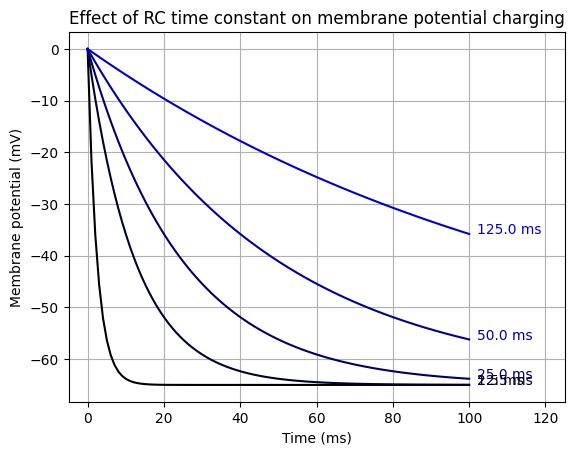

In [47]:
# Plot examples of V changing over time for different RC time constants
tau_factors = [0.1, 0.5, 1, 2, 5]
t = np.linspace(0, 0.1, 100)
for ind, curr_factor in enumerate(tau_factors):
    curr_tau = cell_tau*curr_factor
    plt.plot(t*1e3, e_rest*(1-np.exp(-t/curr_tau))*1e3, 
             label=curr_tau*1e3, color=[0,0,ind/len(tau_factors)])
    plt.text(t[-1]*1e3+2, e_rest*(1-np.exp(-t[-1]/curr_tau))*1e3,
                str(round(curr_tau*1e3,2))+' ms', color=[0,0,ind/len(tau_factors)])
    
    
plt.xlim([-5, 125])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.grid()
plt.title('Effect of RC time constant on membrane potential charging')

What this shows is that longer membrane time constants, $\tau$, slow the rate of change in the membrane potential.

### Creating a passive neuron model
Equation 3 showed us the relationship between time and membrane potential at the moment the membrane capacitance was connected with the leak current. This is, of course, not realistic. Instead, neurons start at the resting potential and recieve occasional inputs that inject currents into the neuron. To capture this, we can use the following equation:

$$ \begin{align} 
    \notag
    0 &= I_{rest} + I_{C} + I_{in}\\ \notag
    0 &=g_{m}(V_{m}-E_{rest}) + C_{m}\frac{dV_{m}}{dt} + I_{in}\\ \notag
    -C\frac{dV_{m}}{dt}&=g_{m}(V_{m}-E_{rest}) + I_{in}\\ \notag
    \frac{dV_{m}}{dt}&=-\frac{1}{C}({g_{m}}(V_{m}-E_{rest}) + I_{in}) \tag{4}
    \end{align}
$$

Since we know how the membrane voltage will change, $\frac{dV_{m}}{dt}$, based on its present value, $V_{m}$, and the current injected, $I_{in}$, we can simulate its response. To do this, we will create a class, `PassiveNeuron`. This class will encapsulate the data and methods needed to simulate the passive properties of a neuron's membrane.

In [117]:
class PassiveNeuron:
    def __init__(self, v_rest=-65, c_m=1, r_m=25, radius=30):
        self._vrest = v_rest/1000 # mV
        self._cm = c_m * 1e-6 # uF/cm^2
        self._rm = r_m * 1e3 # kOhm*cm^2
        self._radius = radius * 1e-4 # cm

        self._area = 4 * np.pi * self._radius**2 # cm^2
        self._c = self._cm * self._area # F  
        self._gleak = 1 / (self._rm / self._area) # S

        self._vm = self._vrest
        self._im = 0
        self._add = 0 # holds additional current to deliver to the neuron
        self._dt = 0.0001 # sec

    def get_tau(self):
        return self._cm * self._rm
    
    def set_input(self, inp=0):
        self._add = inp
    
    def reset_state(self):
        self.__init__()
    
    def get_state(self):
        # return membrane potential in mV, membrane current in nA, and spike status
        return self._vm*1e3, self._im*1e9
    
    def get_t_vec(self, dur = 0.1, dt = 0.0001):
        return np.arange(0, dur, dt)
    
    def update(self):
        # solve for transmembrane currents
        self._im = (self._gleak * (self._vm - self._vrest)) + self._add
        
        # update membrane potential
        self._vm = self._vm + -(self._im / self._c) * self._dt
    
    def run(self, dur=0.1, dt=0.0001, inp=0):

        self.reset_state() # reset state
        
        # initialize arrays to store values
        t = self.get_t_vec(dur, dt) # time array
        v = np.zeros(len(t)) # voltage array
        i = np.zeros(len(t)) # current array
        self._dt = dt # set time step

        # if input is scalar, make it an array
        if isinstance(inp, (int, float)):
            inp = np.ones(len(t)) * inp
        
        # run simulation
        for ind, _ in enumerate(t):
            self.set_input(inp[ind]) # set input current
            self.update() # update membrane potential and current
            v[ind], i[ind] = self.get_state() # store values

        return v, i



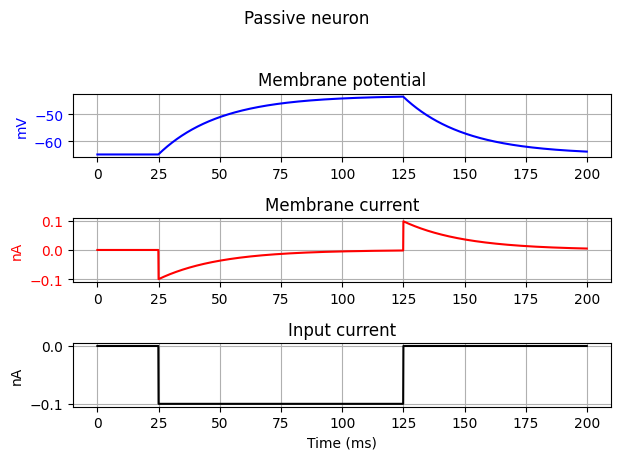

In [129]:
# Create a neuron with default parameters
pas_nrn = PassiveNeuron()
sim_dur = 0.2 # sec
sim_dt = 0.0001 # sec
t_pts = pas_nrn.get_t_vec(dur=sim_dur, dt=sim_dt)

# Create a step current input
def step_current(t, start=0.025, end=0.125, amp=-1e-10):
    step = np.zeros(len(t))
    step[np.where((t>=start)&(t<end))[0]] = amp
    return step

in_step = step_current(t_pts)
pas_v, pas_i = pas_nrn.run(dur=sim_dur, dt=sim_dt, inp=in_step)

def plot_sim(t, v, i, inp, title=''):
    plt.subplot(3,1,1)
    plt.plot(t*1e3, v, color='b')
    plt.yticks(color='b')
    plt.ylabel('mV', color='b')
    plt.grid()
    plt.title('Membrane potential')

    plt.subplot(3,1,2)
    plt.plot(t*1e3, i, color='r')
    plt.yticks(color='r')
    plt.ylabel('nA', color='r')
    plt.title('Membrane current')
    plt.grid()

    plt.subplot(3,1,3)
    plt.plot(t*1e3, inp*1e9, color='k')
    plt.xlabel('Time (ms)')
    plt.yticks(color='k')
    plt.ylabel('nA', color='k')
    plt.title('Input current')
    plt.grid()
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plot_sim(t_pts, pas_v, pas_i, in_step, title='Passive neuron')


When we inject a current step into the neuron, the membrane begins to depolarize from its resting potential towards a new voltage. This is accompanied by an strong current crossing the membrane, which reflects the injected current charging up the membrane capacitance. As the membrane capacitance charges up, this current decays because it is offset by the leak current, which flows in the opposite direction of the injected current. The leak current is driven by the difference between $V_{m}$ and $E_{r}$. For the leak current to balance out the injected current, the membrane potential must reach:

$$ V_{m} = \frac{I_{in}}{g_{leak}}+E_{r}$$

Thus, a increasing $g_{leak}$ (or lowering membrane resistance, $R_{m}$), lowers the change in membrane potential to an injected current. We can see this here:



g_leak for regular model: 5 nS
g_leak for high g model: 5 nS


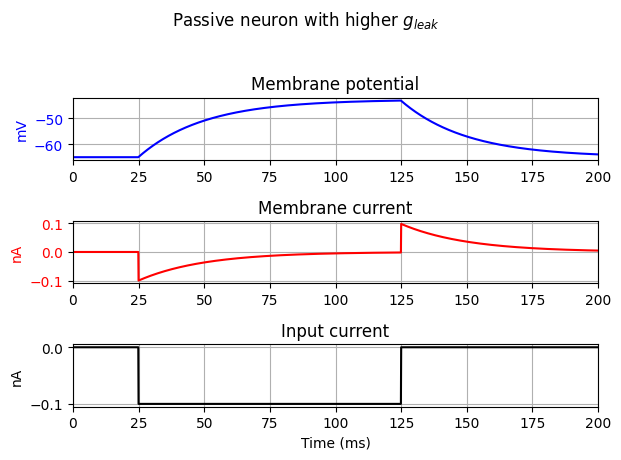

In [119]:
pas_nrn_hig = PassiveNeuron(v_rest=-65, c_m=1, r_m=5, radius=30) # we lowered the membrane resistance, r_m, which increased the membrane conductance, g_m
pas_v_hig, pas_i_hig = pas_nrn_hig.run(dur=sim_dur, dt=sim_dt, inp=in_step)
plot_sim(t_pts, pas_v_hig, pas_i_hig, in_step, title='Passive neuron with higher $g_{leak}$')

# Get values of g_leak for each model
print('g_leak for regular model: {:.0f} nS'.format(pas_nrn._gleak*1e9))
print('g_leak for high g model: {:.0f} nS'.format(pas_nrn_hig._gleak*1e9))

Increasing $g_{leak}$ lowered the change in membrane potential from around 12 mV to 3 mV. Notice also that $V_{m}$ changes much faster now, because the membrane time constant is shorter. 

Increasing the amount of current we inject also increases the change in $V_{m}$.

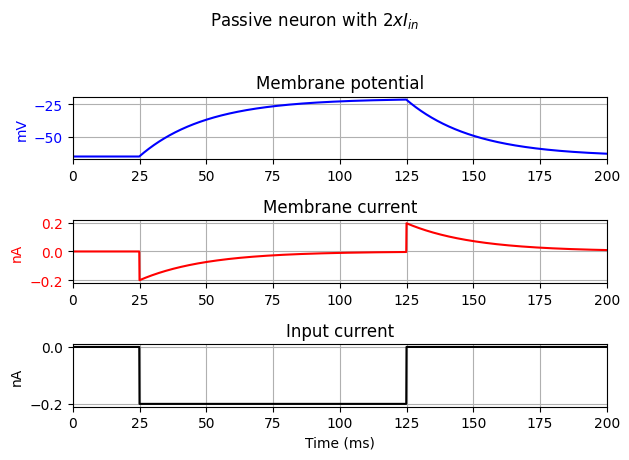

In [120]:
in_step = step_current(t_pts, amp=-2e-10) # increase input current by 2x
pas_v, pas_i = pas_nrn.run(dur=sim_dur, dt=sim_dt, inp=in_step)
plot_sim(t_pts, pas_v, pas_i, in_step, title='Passive neuron with $2xI_{in}$')

So far we have been giving negative current injections, which pushes the membrane towards positive values. If $V_{m}$ moves towards positive values, we say it is *depolarizing*. By contrast, if it is pushed towards negative values, it is *hyperpolarizing*. To hyperpolarize, we inject a positive current.

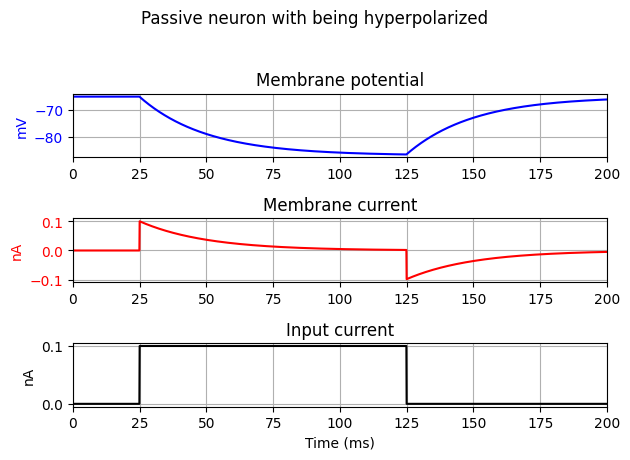

In [121]:
# hyperpolarize the membrane potential
in_step = step_current(t_pts, amp=1e-10)
pas_v, pas_i = pas_nrn.run(dur=sim_dur, dt=sim_dt, inp=in_step)
plot_sim(t_pts, pas_v, pas_i, in_step, title='Passive neuron with being hyperpolarized')

All the activity we have seen so far is slow changes in membrane potential. These are not conveyed to downstream neurons. Instead, neurons have to fire *action potentials* to influence their neighbors.

### Action potentials
Action potentials are large positive excursions of the membrane potential. They last less than 2 ms and propagate from the cell body down the axon, eventually triggering release of neurotransmitter at the synapse. They are the principal output of neurons and, for the most part, the only information about the state of a neuron that is conveyed to the rest of the network.

[INSERT SCHEMATIC OF ACTION POTENTIAL]
To generate an action potential, a neuron is first depolarized to a sufficient level that starts to open voltage-gated Na<sup>+</sup> ion channels. Recalling that Na<sup>+</sup> has a positive reversal potential, their opening will depolarize the membrane voltage. This depolarization recruits more voltage-gated Na<sup>+</sup> ion channels, reinforcing the depolarization and driving the membrane potential towards the Na<sup>+</sup> reversal potential (X). Then, these channels begin to *inactivate*, closing and bringing the membrane back towards its resting potential. This fall back towards rest is accelerated by voltage-dependent K<sup>+</sup> channels, which open during the depolarization of the action potential and drive the membrane towards the K<sup>+</sup> reversal potential (-X).

The voltage-gated Na<sup>+</sup> and K<sup>+</sup> currents are similar in principal to the leak current discussed earlier. They are a battery, the equilibrium potential of Na<sup>+</sup> or K<sup>+</sup>, in series with a conductor. The difference is that the conductor depends on $V_{m}$ and time. We can expand our electrical model of the passive neuron to incorporate these voltage-gated currents, thus allowing us to model action potentials.

[INSERT SCHEMATIC OF ELECTIRCAL MODEL WITH ACTION POTENTIAL, ALONG WITH CURRENT FLOWS DURING THE ACTION POTENTIAL]

The equation that captures this is:

$$ \frac{dV_{m}}{dt}=-\frac{1}{C}(g_{m}(V_{m}-E_{rest}) + g_{Na_{V,t}}(V_{m}-E_{Na}) + g_{K_{V,t}}(V_{m}-E_{K}) + I_{in}) \tag{5} $$

Here $g_{Na_{V,t}}$ is the voltage and time dependent conductance for Na<sup>+</sup>, and similar for $g_{K_{V,t}}$. The driving force for those currents depends on how far $V_{m}$ is from the respective equilibrium potentials of those ions. In essence, increasing $g_{Na_{V,t}}$ or $g_{K_{V,t}}$ pulls $V_{m}$ towards the corresponding equilibrium potential.

### Creating a simplified active neuron model
When we include voltage-gated ion channels in a model neuron, it goes from being a passive model to an *active model*. We can build upon our existing `PassiveNeuron` class to create an `ActiveNeuron` class that generates an approximation of action potentials. To do this, we will add the voltage-dependent Na<sup>+</sup> and K<sup>+</sup> currents. This requires specifying the equilibrium potential for those ions, a $V_{m}$ threshold that initiates the action potential, and designing voltage- and time-dependent conductances to gate the active currents.



[PLACE THIS CODING DISCUSSION IN A LATER LECTURE]
Action potentials are often described as all-or-none events. Either they occur or they do not, and when they do, they tend to always have the same strength and duration. Since they are stereotyped, it is thought that they convey information by their timing. Several different terms are often used to describe the codes offered by action potentials. A *time code* is when the exact time of an action potential indicates the occurrence of some event (whether it be environmental or behavioral). This is often counterposed to a *rate code*, where the informational signal is the how many action potentials occurred in some short amount of time, with a higher rate indicating a 'stronger' signal. Alternatively, a *population code* uses the set of neurons firing action potentials at any given moment to encode information. Different ensembles of activated neurons signal different events.

In [126]:
# create active euron class that inheriting from the passive neuron model
class ActiveNeuron(PassiveNeuron):
    def __init__(self, v_thresh=-50, e_na=50, e_k=-90, g_na=8e-8, g_k=4e-8, **kwargs):
        super().__init__(**kwargs)
        self._vthresh = v_thresh / 1000 # mV
        self._ena = e_na / 1000 # mV
        self._gna = 8e-8 # S
        self._ek = e_k / 1000 # mV
        self._gk = 4e-8 # S
        self._spk_timer = 0
        self._spk = False
    
    def gen_ap(self):
        # action potential mechanism
        if (self._vm > self._vthresh) & (self._spk_timer <= 0):
            self._spk_timer = 0.004 # start countdown timer for duration of action potential
            self._spk = True
        elif self._spk_timer > 0.003:
            self._add = self._add + self._gna * (self._vm - self._ena)
            self._spk = False
            self._spk_timer -= self._dt
        elif self._spk_timer > 0:
            self._add = self._add + self._gk * (self._vm - self._ek)
            self._spk = False
            self._spk_timer -= self._dt

    def run(self, dur=0.1, dt=0.0001, inp=0):

        self.reset_state() # reset state
        
        # initialize arrays to store values
        t = self.get_t_vec(dur, dt) # time array
        v = np.zeros(len(t)) # voltage array
        i = np.zeros(len(t)) # current array
        self._dt = dt # set time step

        # if input is scalar, make it an array
        if isinstance(inp, (int, float)):
            inp = np.ones(len(t)) * inp
        
        # run simulation
        for ind, _ in enumerate(t):
            self.set_input(inp[ind]) # set input current
            self.gen_ap() # generate action potential
            self.update() # update membrane potential and current
            v[ind], i[ind] = self.get_state() # store values

        return v, i

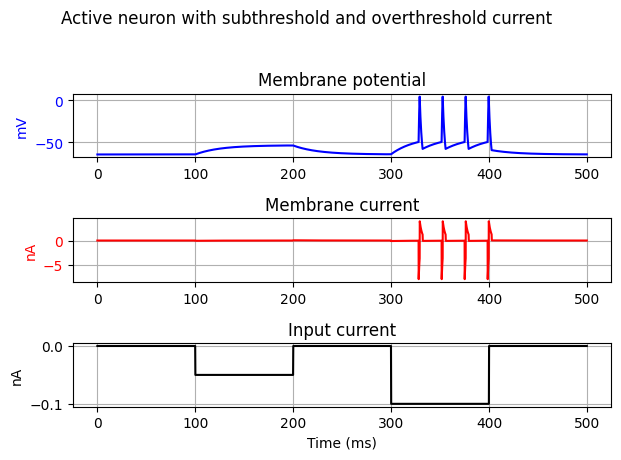

In [132]:
# Create an active neuron and deliver a subthreshold and over threshold current
act_nrn = ActiveNeuron()
sim_dur_act = 0.5
t_pts = act_nrn.get_t_vec(dur=sim_dur_act, dt=sim_dt)
in_step_act = step_current(t_pts, start=0.1, end=0.2, amp=-5e-11) + \
                step_current(t_pts, start=0.3, end=0.4, amp=-1e-10)

act_v, act_i = act_nrn.run(dur=sim_dur_act, dt=sim_dt, inp=in_step_act)
plot_sim(t_pts, act_v, act_i, in_step_act, title='Active neuron with subthreshold and overthreshold current')

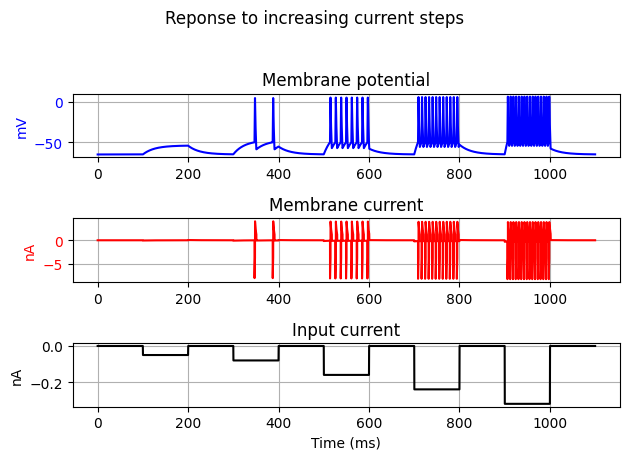

In [133]:
# Examine how firing rate varies with curent injected
act_nrn = ActiveNeuron()
sim_dur_act = 1.1
t_pts = act_nrn.get_t_vec(dur=sim_dur_act, dt=sim_dt)
in_step_act = step_current(t_pts, start=0.1, end=0.2, amp=-5e-11) + \
                step_current(t_pts, start=0.3, end=0.4, amp=-8e-11) + \
                step_current(t_pts, start=0.5, end=0.6, amp=-1.6e-10) + \
                step_current(t_pts, start=0.7, end=0.8, amp=-2.4e-10) + \
                step_current(t_pts, start=0.9, end=1.0, amp=-3.2e-10)

act_v, act_i = act_nrn.run(dur=sim_dur_act, dt=sim_dt, inp=in_step_act)
plot_sim(t_pts, act_v, act_i, in_step_act, title='Reponse to increasing current steps')